In [1]:
using ElectricGrid
using PlotlyJS

In our Implementation we set up our ODE's as linear ODE's. But certainly the real components are nonlinear in most cases.
Thats why we added a way to describe the nonlinearity regarding the voltage and the current and solve it with any ODE'solvers from [DifferentialEquations](https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/). 

In the following I'm going to setup an easy Example which you can see in ... 
#todo Marvin

In [2]:
CM = [0. 1.
     -1. 0.]

S_source = 1e4
S_load = 1e2
pf_load = 1
v_rms = 230
R_load, L_load, X, Z = ParallelLoadImpedance(S_load, pf_load, v_rms);

As you will see, one linear and one nonlinear parameter dict is set up. And the nonlinear on just uses a constant function such that the Result should be comparable.
You can find it under the key cable and then L.

In [3]:
parameters_linear = Dict{Any, Any}(
    "source" => Any[
                    Dict{Any, Any}("pwr" => S_source, "control_type" => "classic", "mode" => "Swing", "fltr" => "LC", "i_limit" => 1e4, "v_limit" => 1e4,),
                    ],
    "load"   => Any[
                    Dict{Any, Any}("impedance" => "R", "R" => R_load, "v_limit" => 1e4, "i_limit" => 1e4)
                    ],
    "cable"   => Any[
                    Dict{Any, Any}("R" => 1e-3, "L" => 1e-4, "C" => 1e-4),
                    ],
    "grid" => Dict{Any, Any}("fs"=>1e4, "phase"=>3, "v_rms"=>230, "f_grid" => 50, "ramp_end"=>0.00)
)

env_linear = ElectricGridEnv(CM = CM, parameters = parameters_linear, verbosity = 2);

┌ Info: Normalization is done based on the defined parameter limits.
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/electric_grid_env.jl:309
┌ Info: Time simulation run time: 0.0499 [s] ~> 500 steps
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/electric_grid_env.jl:310


In [4]:
parameters_nonlinear = Dict{Any, Any}(
    "source" => Any[
                    Dict{Any, Any}("pwr" => S_source, "control_type" => "classic", "mode" => "Swing", "fltr" => "LC", "i_limit" => 1e4, "v_limit" => 1e4,),
                    ],
    "load"   => Any[
                    Dict{Any, Any}("impedance" => "R", "R" => R_load, "v_limit" => 1e4, "i_limit" => 1e4)
                    ],
    "cable"   => Any[
                    Dict{Any, Any}("R" => 1e-3, "L" => x->1e-4, "C" => 1e-4),
                    ],
    "grid" => Dict{Any, Any}("fs"=>1e4, "phase"=>3, "v_rms"=>230, "f_grid" => 50, "ramp_end"=>0.00)
)

env_nonlinear = ElectricGridEnv(CM = CM, parameters = parameters_nonlinear, t_end = 0.04, verbosity = 2, nonlinear_solver = SSPRK33());

┌ Info: Nonlinear Solver: Use SSPRK33 as solver.
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/electric_grid_env.jl:165
┌ Info: Normalization is done based on the defined parameter limits.
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/electric_grid_env.jl:309
┌ Info: Time simulation run time: 0.04 [s] ~> 401 steps
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/electric_grid_env.jl:310


In [5]:
GetStateIds(env_linear.nc)

15-element Vector{String}:
 "source1_i_L1_a"
 "source1_v_C_filt_a"
 "source1_v_C_cables_a"
 "cable1_i_L_a"
 "load1_v_C_total_a"
 "source1_i_L1_b"
 "source1_v_C_filt_b"
 "source1_v_C_cables_b"
 "cable1_i_L_b"
 "load1_v_C_total_b"
 "source1_i_L1_c"
 "source1_v_C_filt_c"
 "source1_v_C_cables_c"
 "cable1_i_L_c"
 "load1_v_C_total_c"

As you can see in the list from above the 3rd value in the list is ... Thats why we choose it and compare it linearly and nonlinearly

In [6]:
value = 14

sol_linear = []
for i = 1:500
    env_linear([0.5, 0.5, 0.5])
    append!(sol_linear,env_linear.x[value])
end

In [7]:
sol_nonlinear = []
for i = 1:500
    env_nonlinear([0.5, 0.5, 0.5])
    append!(sol_nonlinear,env_nonlinear.x[value])
end

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

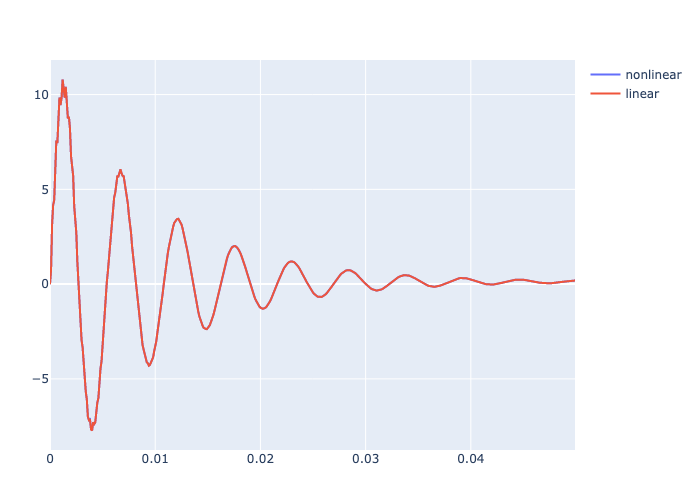

In [8]:
t_nonlinear = collect(env_nonlinear.t0:env_nonlinear.ts:env_nonlinear.t)
p_nonlinear = scatter(x=t_nonlinear,y=sol_nonlinear,mode="lines",name="nonlinear")

t_linear = collect(env_linear.t0:env_linear.ts:env_linear.t)
p_linear = scatter(x=t_linear,y=sol_linear,mode="lines",name="linear")

plot([p_nonlinear,p_linear])

As you can not see here. Any differences. Because it's alomost the same when you compare it to the linear solver.

Other orbitrary function which you can see in the figure below. [Function origin](https://onlinelibrary.wiley.com/doi/full/10.1002/cta.3147)


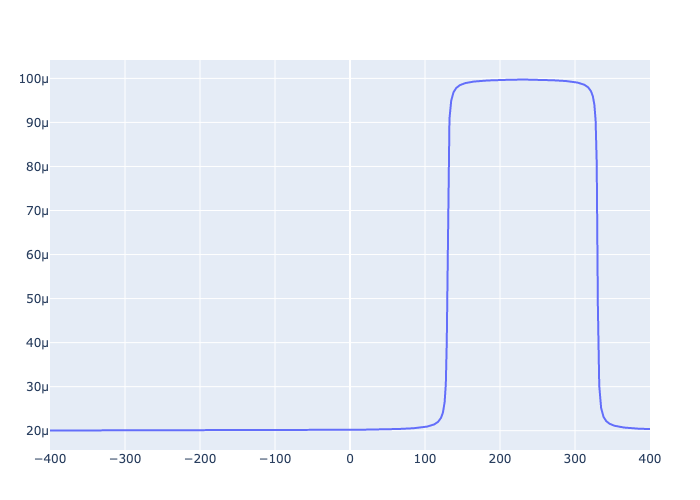

In [9]:
#todo value noch umbenennen!!!
function NonlinearInductance(L_low,L_high,smoothness,value)
    return x -> L_low + (L_high - L_low) / 2 * (1 - 2/π * atan( smoothness * (abs(x-230)-value)))
end

l = NonlinearInductance(2e-5,1e-4,1,100)
# l = NonlinearInductance(1e-4,1e-4,0.1,330)

x = collect(-400:0.1:400)
y = l.(x)

plot(x,y)


In [10]:
# Change of the nonlinear cable parameter. And calculating of the rest as shown before.
parameters_nonlinear_new = parameters_nonlinear
parameters_nonlinear_new["cable"][1]["L"] = l
env_nonlinear = ElectricGridEnv(CM = CM, parameters = parameters_nonlinear_new, verbosity = 2, nonlinear_solver = SSPRK33());
env_linear = ElectricGridEnv(CM = CM, parameters = parameters_linear, verbosity = 2);

┌ Info: Nonlinear Solver: Use SSPRK33 as solver.
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/electric_grid_env.jl:165
┌ Info: Normalization is done based on the defined parameter limits.
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/electric_grid_env.jl:309
┌ Info: Time simulation run time: 0.0499 [s] ~> 500 steps
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/electric_grid_env.jl:310
┌ Info: Normalization is done based on the defined parameter limits.
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/electric_grid_env.jl:309
┌ Info: Time simulation run time: 0.0499 [s] ~> 500 steps
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/electric_grid_env.jl:310


In [11]:
value = 14

sol_linear = []
for i = 1:200
    env_linear([0.5, 0.5, 0.5])
    append!(sol_linear,env_linear.x[value])
end

sol_nonlinear = []
for i = 1:200
    env_nonlinear([0.5, 0.5, 0.5])
    append!(sol_nonlinear,env_nonlinear.x[value])
end

t_nonlinear = collect(env_nonlinear.t0:env_nonlinear.ts:env_nonlinear.t)
p_nonlinear = scatter(x=t_nonlinear,y=sol_nonlinear,mode="lines",name="nonlinear")

t_linear = collect(env_linear.t0:env_linear.ts:env_linear.t)
p_linear = scatter(x=t_linear,y=sol_linear,mode="lines",name="linear")

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /Users/benediktbrueck/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the ne

scatter with fields mode, name, type, x, and y


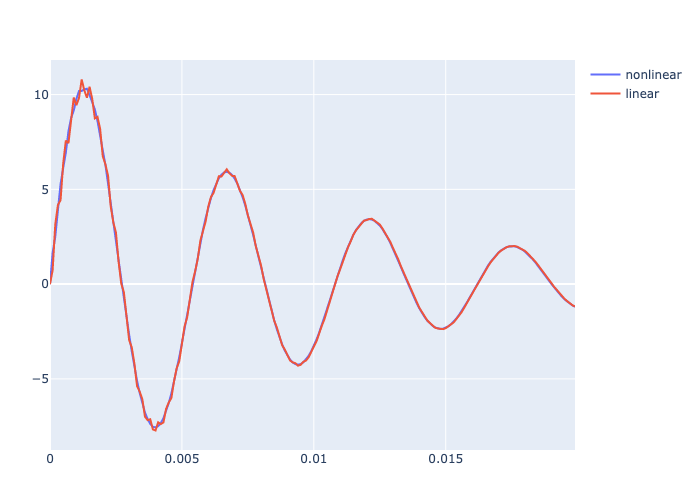

In [12]:
plot([p_nonlinear,p_linear])